# **CS224W - Colab 3**

In Colab 2 we constructed GNN models by using PyTorch Geometric's built in GCN layer, `GCNConv`. In this Colab we will go a step deeper and implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.

**Note**: Make sure to **sequentially run all the cells in each section** so that the intermediate variables / packages will carry over to the next cell

Have fun and good luck on Colab 3 :)

# Device
We recommend using a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [1]:
# Install torch geometric
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.11.0+cu113


In [2]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.8 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 4.1 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 4.9 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 4.8 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 407 kB 4.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=47c8917965c0e195a2ebe5c45e500c292e4ad51423ad0f03441b11ab8d2d3958
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [3]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

# 1) GNN Layers

## Implementing Layer Modules

In Colab 2, we implemented a GCN model for node and graph classification tasks. However, for that notebook we took advantage of PyG's built in GCN module. For Colab 3, we provide a build upon a general Graph Neural Network Stack, into which we will be able to plugin our own module implementations: GraphSAGE and GAT.

We will then use our layer implemenations to complete node classification on the CORA dataset, a standard citation network benchmark. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node or document in the graph is assigned a class label and features based on the documents binarized bag-of-words representation. Specifically, the Cora graph has 2708 nodes, 5429 edges, 7 prediction classes, and 1433 features per node. 

## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**, etc. This module is provided for you. Your implementations of the **GraphSage** and **GAT** (Colab 4) layers will function as components in the GNNStack Module.

In [4]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            
            # When applying GAT with num heads > 1, you need to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.

            # HINT: In case you want to play with multiheads, you need to change the for-loop that builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Creating Our Own Message Passing Layer

Now let's start implementing our own message passing layers! Working through this part will help us become acutely familiar with the behind the scenes work of implementing Pytorch Message Passing Layers, allowing us to build our own GNN models. To do so, we will work with and implement 3 critcal functions needed to define a PyG Message Passing Layer: `forward`, `message`, and `aggregate`.

Before diving head first into the coding details, let us quickly review the key components of the message passing process. To do so, we will focus on a single round of messsage passing with respect to a single central node $x$. Before message passing, $x$ is associated with a feature vector $x^{l-1}$, and the goal of message passing is to update this feature vector as $x^l$. To do so, we implement the following steps: 1) each neighboring node $v$ passes its current message $v^{l-1}$ across the edge $(x, v)$ - 2) for the node $x$, we aggregate all of the messages of the neighboring nodes (for example through a sum or mean) - and 3) we transform the aggregated information by for example applying linear and non-linear transformations. Altogether, the message passing process is applied such that every node $u$ in our graph updates its embedding by acting as the central node $x$ in step 1-3 described above. 

Now, we extending this process to that of a single message passing layer, the job of a message passing layer is to update the current feature representation or embedding of each node in a graph by propagating and transforming information within the graph. Overall, the general paradigm of a message passing layers is: 1) pre-processing -> 2) **message passing** / propagation -> 3) post-processing. 

The `forward` fuction that we will implement for our message passing layer captures this execution logic. Namely, the `forward` function handles the pre and post-processing of node features / embeddings, as well as initiates message passing by calling the `propagate` function. 


The `propagate` function encapsulates the message passing process! It does so by calling three important functions: 1) `message`, 2) `aggregate`, and 3) `update`. Our implementation will vary slightly from this, as we will not explicitly implement `update`, but instead place the logic for updating node embeddings after message passing and within the `forward` function. To be more specific, after information is propagated (message passing), we can further transform the node embeddings outputed by `propagate`. Therefore, the output of `forward` is exactly the node embeddings after one GNN layer.

Lastly, before starting to implement our own layer, let us dig a bit deeper into each of the functions described above:

1. 

```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
Calling `propagate` initiates the message passing process. Looking at the function parameters, we highlight a couple of key parameters. 

  - `edge_index` is passed to the forward function and captures the edge structure of the graph.
  - `x=(x_i, x_j)` represents the node features that will be used in message passing. In order to explain why we pass the tuple `(x_i, x_j)`, we first look at how our edges are represented. For every edge $(i, j) \in \mathcal{E}$, we can differentiate $i$ as the source or central node ($x_{central}$) and j as the neighboring node ($x_{neighbor}$). 
  
    Taking the example of message passing above, for a central node $u$ we will aggregate and transform all of the messages associated with the nodes $v$ s.t. $(u, v) \in \mathcal{E}$ (i.e. $v \in \mathcal{N}_{u}$). Thus we see, the subscripts `_i` and `_j` allow us to specifcally differenciate features associated with central nodes (i.e. nodes  recieving message information) and neighboring nodes (i.e. nodes passing messages). 

    This is definitely a somewhat confusing concept; however, one key thing to remember / wrap your head around is that depending on the perspective, a node $x$ acts as a central node or a neighboring node. In fact, in undirected graphs we store both edge directions (i.e. $(i, j)$ and $(j, i)$). From the central node perspective, `x_i`, x is collecting neighboring information to update its embedding. From a neighboring node perspective, `x_j`, x is passing its message information along the edge connecting it to a different central node.

  - `extra=(extra_i, extra_j)` represents additional information that we can associate with each node beyond its current feature embedding. In fact, we can include as many additional parameters of the form `param=(param_i, param_j)` as we would like. Again, we highlight that indexing with `_i` and `_j` allows us to differentiate central and neighboring nodes. 

  The output of the `propagate` function is a matrix of node embeddings after the message passing process and has shape $[N, d]$.

2. 
```
def message(x_j, ...):
```
The `message` function is called by propagate and constructs the messages from
neighboring nodes $j$ to central nodes $i$ for each edge $(i, j)$ in *edge_index*. This function can take any argument that was initially passed to `propagate`. Furthermore, we can again differentiate central nodes and neighboring nodes by appending `_i` or `_j` to the variable name, .e.g. `x_i` and `x_j`. Looking more specifically at the variables, we have:

  - `x_j` represents a matrix of feature embeddings for all neighboring nodes passing their messages along their respective edge (i.e. all nodes $j$ for edges $(i, j) \in \mathcal{E}$). Thus, its shape is $[|\mathcal{E}|, d]$!
  - In implementing GAT we will see how to access additional variables passed to propagate

  Critically, we see that the output of the `message` function is a matrix of neighboring node embeddings ready to be aggregated, having shape $[|\mathcal{E}|, d]$.

3. 
```
def aggregate(self, inputs, index, dim_size = None):
```
Lastly, the `aggregate` function is used to aggregate the messages from neighboring nodes. Looking at the parameters we highlight:

  - `inputs` represents a matrix of the messages passed from neighboring nodes (i.e. the output of the `message` function).
  - `index` has the same shape as `inputs` and tells us the central node that corresponding to each of the rows / messages $j$ in the `inputs` matrix. Thus, `index` tells us which rows / messages to aggregate for each central node.

  The output of `aggregate` is of shape $[N, d]$.


For additional resources refer to the PyG documentation for implementing custom message passing layers: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

## GraphSage Implementation

For our first GNN layer, we will implement the well known GraphSage ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer! 

For a given *central* node $v$ with current embedding $h_v^{l-1}$, the message passing update rule to tranform $h_v^{l-1} \rightarrow h_v^l$ is as follows: 

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $W_1$ and $W_2$ are learanble weight matrices and the nodes $u$ are *neighboring* nodes. Additionally, we use mean aggregation for simplicity:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

One thing to note is that we're adding a **skip connection** to our GraphSage implementation through the term $W_l\cdot h_v^{(l-1)}$. 

Before implementing this update rule, we encourage you to think about how different parts of the formulas above correspond with the functions outlined earlier: 1) `forward`, 2) `message`, and 3) `aggregate`. As a hint, we are given what the aggregation function is (i.e. mean aggregation)! Now the question remains, what are the messages passed by each neighbor nodes and when do we call the `propagate` function? 

Note: in this case the message function or messages are actually quite simple. Additionally, remember that the `propagate` function encapsulates the operations of / the outputs of the combined `message` and `aggregate` functions.


Lastly, $\ell$-2 normalization of the node embeddings is applied after each iteration.


<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>

In [5]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Don't forget the bias!
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        ############################################################################
        self.lin_l = nn.Linear(self.in_channels, self.out_channels, bias=True)
        self.lin_r = nn.Linear(self.in_channels, self.out_channels, bias=True)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters() 

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x). 
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        #
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        ############################################################################
        # linearly transform x

        x_prop = self.propagate(edge_index, x=(x,x), size=size)
        x = self.lin_l(x) + x_prop
        
        if self.normalize:
            x = F.normalize(x)
        out=x

        # # call propagate to conduct message passing
        # propagated_output_l = self.propagate(x, x=x)
        # propagated_output_r = self.propagate(edge_index, x=x)

        # # update with skip connection from previous layer
        # out = (self.lin_l * propagated_output_l) + (self.lin_r * self.aggregate(propagated_output_r))

        # if self.normalize:
        #     out /= torch.linalg.norm(out, dim=2)

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on 
        # what message each neighboring node passes.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        ############################################################################
        out = self.lin_r(x_j)

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')

        ############################################################################

        return out


## GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, we will see how attention mechanisms can be used to perform node classification of graph-structured data through the usage of Graph Attention Networks (GATs).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function . Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe this transformation of the input features into higher-level features performed by each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. Next, we perform self-attention on the nodes. We use a shared attentional mechanism:
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

This mechanism computes the attention coefficients that capture the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. To utilize graph structure in the attention mechanisms, we can use masked attention. In masked attention, we only compute $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vector $\overrightarrow{a} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]$ and $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.

In [6]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using 
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
#         assert (self.out_channels % self.heads == 0), "Out channel size needs to be div by heads"
        self.lin_l = nn.Linear(self.in_channels, self.heads*self.out_channels)

        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here! 
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.att_l = nn.Parameter(torch.randn(heads, self.out_channels)) #Head x C
        self.att_r = nn.Parameter(torch.randn(heads, self.out_channels)) #Head x C


        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        x_l = self.lin_l(x).view(-1, H, C) #N x H x C
        x_r = self.lin_r(x).view(-1, H, C) #N x H x C
                                                
        alpha_l = self.att_l.unsqueeze(0)*x_l #1 x H x C * N x H x C 
        alpha_r = self.att_r.unsqueeze(0)*x_r #1 x H x C * N x H x C
        
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r))
        out = out.view(-1, H*C)
        
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        alpha_ij = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        
        if ptr is not None:
            alpha_ij = softmax(alpha_ij, ptr)
        else:
            alpha_ij = softmax(alpha_ij, index)
            
        alpha_ij = F.dropout(alpha_ij, p=self.dropout)
        
        out = x_j * alpha_ij
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        # The axis along which to index number of nodes.
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce="sum")

        ############################################################################
    
        return out

## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.

In [7]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [8]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!

**Submit your best accuracy and loss on Gradescope.**

Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:57<00:00,  8.69Epochs/s]


Maximum test set accuracy: 0.8
Minimum loss: 0.09282984584569931
Saving Model Predictions for Model Type GraphSage

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:17<00:00,  6.46Epochs/s]


Maximum test set accuracy: 0.8
Minimum loss: 0.030625026673078537
Saving Model Predictions for Model Type GAT



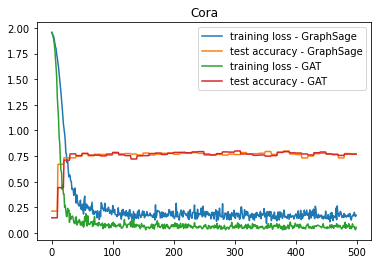

In [9]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()


## Question 1.1: What is the maximum accuracy obtained on the test set for GraphSage? (10 points)

Running the cell above will show the results of your best model and save your best model's predictions to a file named *CORA-Node-GraphSage.csv*.  

As we have seen before you can view this file by clicking on the *Folder* icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.

# 2 DeepSNAP Basics

In previous Colabs we used both of graph class (NetworkX) and tensor (PyG) representations of graphs separately. The graph class `nx.Graph` provides rich analysis and manipulation functionalities, such as the clustering coefficient and PageRank. To feed the graph into the model, we need to transform the graph into tensor representations including edge tensor `edge_index` and node attributes tensors `x` and `y`. But only using tensors (as the graphs formatted in PyG `datasets` and `data`) will make many graph manipulations and analysis less efficient and harder. So, in this Colab we will use DeepSNAP which combines both representations and offers a full pipeline for GNN training / validation / testing.


In general, [DeepSNAP](https://github.com/snap-stanford/deepsnap) is a Python library to assist efficient deep learning on graphs. DeepSNAP features in its support for flexible graph manipulation, standard pipeline, heterogeneous graphs and simple API.

1. DeepSNAP is easy to be used for the sophisticated graph manipulations, such as feature computation, pretraining, subgraph extraction etc. during/before the training.
2. In most frameworks, standard pipelines for node, edge, link, graph-level tasks under inductive or transductive settings are left to the user to code. In practice, there are additional design choices involved (such as how to split dataset for link prediction). DeepSNAP provides such a standard pipeline that greatly saves repetitive coding efforts, and enables fair comparision for models.
3. Many real-world graphs are heterogeneous graphs. But packages support for heterogeneous graphs, including data storage and flexible message passing, is lacking. DeepSNAP provides an efficient and flexible heterogeneous graph that supports both the node and edge heterogeneity.

[DeepSNAP](https://github.com/snap-stanford/deepsnap) is a newly released project and it is still under development. If you find any bugs or have any improvement ideas, feel free to raise issues or create pull requests on the GitHub directly :)

In this Colab, we will focus on DeepSNAP graph manipulations and splitting settings.

## Setup

In [ ]:
!pip install deepsnap

In [12]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

def visualize(G, color_map=None, seed=123):
    if color_map is None:
        color_map = '#c92506'
    plt.figure(figsize=(8, 8))
    nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
                                 label=None, node_color=color_map, node_shape='o', node_size=150)
    edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
    if color_map is not None:
        plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
        plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
        plt.legend(prop={'size': 13}, handletextpad=0)
    nodes.set_edgecolor('black')
    plt.show()

## DeepSNAP Graph

The `deepsnap.graph.Graph` class is the core class of DeepSNAP. It not only represents a graph in tensor format but also references to a graph object from graph manipulation package.

Currently DeepSNAP supports [NetworkX](https://networkx.org/) and [Snap.py](https://snap.stanford.edu/snappy/doc/index.html) as the back end graph manipulation package.

In this Colab, we will use the NetworkX as the back end graph manipulation package.

Lets first try to convert a simple random NetworkX graph to a DeepSNAP graph.

(0, {'node_feature': tensor([0.5192, 0.6305, 0.9388, 0.5455, 0.8188]), 'node_label': tensor(0)})


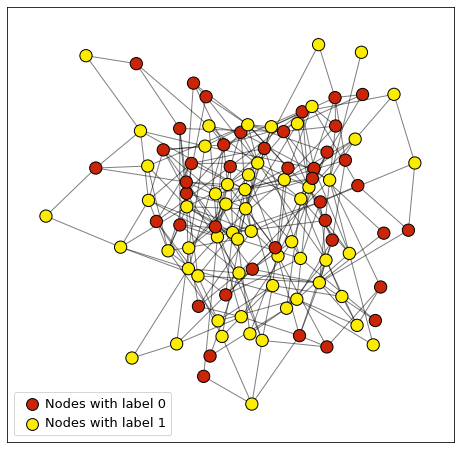

Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])
Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64
Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64
The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manupulation graph


In [13]:
num_nodes = 100
p = 0.05
seed = 100

# Generate a networkx random graph
G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# Generate some random node features and labels
node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

# Set the random features and labels to G
nx.set_node_attributes(G, node_feature, name='node_feature')
nx.set_node_attributes(G, node_label, name='node_label')

# Print one node example
for node in G.nodes(data=True):
    print(node)
    break

color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]

# Visualize the graph
visualize(G, color_map=color_map)

# Transform the networkx graph into the deepsnap graph
graph = Graph(G)

# Print out the general deepsnap graph information
print(graph)

# DeepSNAP will convert node attributes to tensors
# Notice the type of tensors
print("Node feature (node_feature) has shape {} and type {}".format(graph.node_feature.shape, graph.node_feature.dtype))
print("Node label (node_label) has shape {} and type {}".format(graph.node_label.shape, graph.node_label.dtype))

# DeepSNAP will also generate the edge_index tensor
print("Edge index (edge_index) has shape {} and type {}".format(graph.edge_index.shape, graph.edge_index.dtype))

# Different from only storing tensors, deepsnap graph also references to the networkx graph
# We will discuss why the reference will be helpful later
print("The DeepSNAP graph has {} as the internal manupulation graph".format(type(graph.G)))

In DeepSNAP we have three levels of attributes. In this example, we have the **node level** attributes including `node_feature` and `node_label`. The other two levels of attributes are graph and edge attributes. The usage is similar to the node level one except that the feature becomes `edge_feature` or `graph_feature` and label becomes `edge_label` or `graph_label` etc.

Similar to the NetworkX graph, we can easily get some basic information of the graph through class properties directly.

In [14]:
# Number of nodes
print("The random graph has {} nodes".format(graph.num_nodes))

# Number of edges
print("The random graph has {} edges".format(graph.num_edges))

The random graph has 100 nodes
The random graph has 262 edges


DeepSNAP also provides functions that can automatically transform the PyG datasets into a list of DeepSNAP graphs.

Here we transform the CORA dataset into a list of DeepSNAP graphs.

In [15]:
root = './tmp/cora'
name = 'Cora'

# The Cora dataset
pyg_dataset= Planetoid(root, name)

# PyG dataset to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Get the first deepsnap graph (CORA only has one graph)
graph = graphs[0]
print(graph)

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


Processing...
Done!


## Question 2.1: What is the number of classes and number of features in the CORA graph? (5 points)

Submit your answers on Gradescope.

In [16]:
def get_num_node_classes(graph):
    # TODO: Implement this function that takes a deepsnap graph object
    # and return the number of node classes of that graph.

    num_node_classes = 0

    ############# Your code here #############
    ## (~1 line of code)
    ## Note
    ## 1. Colab autocomplete functionality might be useful
    ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
    num_node_classes = graph.num_node_labels

    ##########################################

    return num_node_classes

def get_num_node_features(graph):
    # TODO: Implement this function that takes a deepsnap graph object
    # and return the number of node features of that graph.

    num_node_features = 0

    ############# Your code here #############
    ## (~1 line of code)
    ## Note
    ## 1. Colab autocomplete functionality might be useful
    ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
    num_node_features = graph.num_node_features

    ##########################################

    return num_node_features

num_node_classes = get_num_node_classes(graph)
num_node_features = get_num_node_features(graph)
print("{} has {} classes".format(name, num_node_classes))
print("{} has {} features".format(name, num_node_features))

Cora has 7 classes
Cora has 1433 features


## DeepSNAP Dataset

Now, lets talk about DeepSNAP dataset. A `deepsnap.dataset.GraphDataset` contains a list of `deepsnap.graph.Graph` objects. In addition to list of graphs, you can also specify what task the dataset will be used on, such as node level task (`task=node`), edge level task (`task=link_pred`) and graph level task (`task=graph`).

It also contains many other useful parameters during initialization and other functinoalities. If you are interested, you can take a look at the [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset).

In [17]:
root = './tmp/cox2'
name = 'COX2'

# Load the dataset through PyG
pyg_dataset = TUDataset(root, name)

# Convert to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Convert list of deepsnap graphs to deepsnap dataset with specified task=graph
dataset = GraphDataset(graphs, task='graph')
print(dataset)

Extracting tmp/cox2/COX2/COX2.zip
Processing...
Done!


GraphDataset(467)


## Question 2.2: What is the label of the graph (index 100 in the COX2 dataset)? (5 points)

Submit your answers on Gradescope.

In [18]:
def get_graph_class(dataset, idx):
    # TODO: Implement this function that takes a deepsnap dataset object,
    # the index of the graph in the dataset, and returns the class/label 
    # of the graph (in integer).

    label = -1

    ############# Your code here ############
    ## (~1 line of code)
    ## Note
    ## 1. The label refers to the graph-level attribute
    label = dataset[idx].graph_label 

    #########################################

    return label

graph_0 = dataset[100]
print(graph_0)
idx = 100
label = get_graph_class(dataset, idx)
print('Graph with index {} has label {}'.format(idx, label))

Graph(G=[], edge_index=[2, 78], edge_label_index=[2, 78], graph_label=[1], node_feature=[37, 35], node_label_index=[37], task=[])
Graph with index 100 has label tensor([0])


## Question 2.3: What is the number of edges for the graph (index 200 in the COX2 dataset)? (5 points)

Submit your answers on Gradescope.

In [19]:
def get_graph_num_edges(dataset, idx):
    # TODO: Implement this function that takes a deepsnap dataset object,
    # the index of the graph in dataset, and returns the number of 
    # edges in the graph (in integer).

    num_edges = 0

    ############# Your code here ############
    ## (~1 lines of code)
    ## Note
    ## 1. You can use the class property directly
    num_edges = dataset[idx].num_edges

    #########################################

    return num_edges

idx = 200
num_edges = get_graph_num_edges(dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 49 edges


# 3 DeepSNAP Advanced

We have learned the basic use of DeepSNAP graph and dataset :)

Lets move on to some more advanced functionalities.

In this section we will use DeepSNAP for faeture computation and transductive/inductive splittings.

In [20]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

## Data Split in Graphs

Data splitting in graphs can be much harder than that in CV or NLP.

In general, the data splitting in graphs can be divided into two settings, **inductive** and **transductive**.

## Inductive Split

As what we have learned in the lecture, inductive setting will split multiple graphs into each training/valiation and test sets.

Here is an example of DeepSNAP inductive splitting for a list of graphs in the graph level task (graph classification etc.)

In [21]:
root = './tmp/cox2'
name = 'COX2'

pyg_dataset = TUDataset(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as graph-level task such as graph classification
task = 'graph'
dataset = GraphDataset(graphs, task=task)

# Specify transductive=False (inductive)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

print("COX2 train dataset: {}".format(dataset_train))
print("COX2 validation dataset: {}".format(dataset_val))
print("COX2 test dataset: {}".format(dataset_test))

COX2 train dataset: GraphDataset(373)
COX2 validation dataset: GraphDataset(46)
COX2 test dataset: GraphDataset(48)


## Transductive Split

In transductive setting, the training /validation / test sets are on the same graph.

Here we transductively split the CORA graph in the node level task. 

(Notice that in DeepSNAP default setting the split is random, but you can also make a fixed split by specifying `fixed_split=True` when loading the dataset from PyG or changing the `node_label_index` directly).

In [22]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as node-level task such as node classification
task = 'node'

dataset = GraphDataset(graphs, task=task)

# Specify we want the transductive splitting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

# The nodes in each set can be find in node_label_index
print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)
Original Cora has 2708 nodes
After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


## Edge Level Split

Compared to the node and graph level splitting, edge level splitting is a little bit tricky ;)

Usually in edge level splitting, we need to sample negative edges, split positive edges into different datasets, split training edges into message passing edges and supervision edges, and resample the negative edges during the training etc.

### All Mode

Now lets start with a simpler edge level splitting mode, the `edge_train_mode="all"` mode in DeepSNAP.

In [23]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, "all" mode is default for deepsnap dataset
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In DeepSNAP, the indices of supervision edges are stored in `edge_label_index` tensor and the corresponding edge labels are stored in `edge_label` tensor.

In [24]:
print("Original Cora graph has {} edges".format(dataset[0].num_edges))
print("Because Cora graph is undirected, the original edge_index has shape {}".format(dataset[0].edge_index.shape))

print("The training set has message passing edge index shape {}".format(dataset_train[0].edge_index.shape))
print("The training set has supervision edge index shape {}".format(dataset_train[0].edge_label_index.shape))

print("The validation set has message passing edge index shape {}".format(dataset_val[0].edge_index.shape))
print("The validation set has supervision edge index shape {}".format(dataset_val[0].edge_label_index.shape))

print("The test set has message passing edge index shape {}".format(dataset_test[0].edge_index.shape))
print("The test set has supervision edge index shape {}".format(dataset_test[0].edge_label_index.shape))

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])
The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])
The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


We can see that both training and validation sets have the same message passing edges (`edge_index`) in the `all` mode. Also, in training set, the postive supervision edges (`edge_label_index`) are same with the message passing edges. However, in the test set the message passing edges are the combination of message passing edges from training and validation sets.

Notice that the `edge_label` and `edge_label_index` have included the negative edges (default number of negative edges is same with the number of positive edges).

Now, lets implement a function that checks whether two edge index tensors are disjoint and explore more edge splitting properties by using that function.

## Question 3.1 - 3.5: Implement the function that checks whether two edge_index tensors are disjoint. Then answer the True/False questions below. (5 points)

Submit your answers on Gradescope.

In [25]:
def edge_indices_disjoint(edge_index_1, edge_index_2):
    # TODO: Implement this function that takes two edge index tensors,
    # and returns whether these two edge index tensors are disjoint.
    disjoint = None

    ############# Your code here ############
    ## (~5 lines of code)
    ## Note
    ## 1. Here disjoint means that there is no single edge belongs to either edge index tensors
    ## 2. You do not need to consider the undirected case. For example, if edge_index_1 contains
    ## edge (a, b) and edge_index_2 contains edge (b, a). We will treat them as disjoint in this
    ## function.
    edge_index_1_np = edge_index_1.T.detach().cpu().numpy()
    edge_index_2_np = edge_index_2.T.detach().cpu().numpy() 
#     print(edge_index_1.shape)
    
    intersect_np = \
    [x for x in set(tuple(x) for x in edge_index_1_np) & set(tuple(x) for x in edge_index_2_np)]

    disjoint =  len(intersect_np) == 0
    #########################################

    return disjoint

In [26]:
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
print("3.1 Training (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)))

num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
print("3.2 Validation (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)))

num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
print("3.3 Test (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)))

print("3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)))
print("3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)))

3.1 Training (supervision) positve and negative edges are disjoint = True
3.2 Validation (supervision) positve and negative edges are disjoint = True
3.3 Test (supervision) positve and negative edges are disjoint = True
3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = True
3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = True


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


### Disjoint Mode

Now lets look at a relatively more complex transductive edge split setting, which is the `edge_train_mode="disjoint"` mode in DeepSNAP (also the transductive link prediction splitting talked in the lecture)

In [27]:
edge_train_mode = "disjoint"

dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
orig_edge_index = dataset[0].edge_index
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_message_edge_index = dataset_train[0].edge_index
train_sup_edge_index = dataset_train[0].edge_label_index
val_sup_edge_index = dataset_val[0].edge_label_index
test_sup_edge_index = dataset_test[0].edge_label_index

print("The edge index of original graph has shape: {}".format(orig_edge_index.shape))
print("The edge index of training message edges has shape: {}".format(train_message_edge_index.shape))
print("The edge index of training supervision edges has shape: {}".format(train_sup_edge_index.shape))
print("The edge index of validation message edges has shape: {}".format(dataset_val[0].edge_index.shape))
print("The edge index of validation supervision edges has shape: {}".format(val_sup_edge_index.shape))
print("The edge index of test message edges has shape: {}".format(dataset_test[0].edge_index.shape))
print("The edge index of test supervision edges has shape: {}".format(test_sup_edge_index.shape))

The edge index of original graph has shape: torch.Size([2, 10556])
The edge index of training message edges has shape: torch.Size([2, 6754])
The edge index of training supervision edges has shape: torch.Size([2, 3380])
The edge index of validation message edges has shape: torch.Size([2, 8444])
The edge index of validation supervision edges has shape: torch.Size([2, 2108])
The edge index of test message edges has shape: torch.Size([2, 9498])
The edge index of test supervision edges has shape: torch.Size([2, 2116])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


You can see that the training / validation message passing edges and training supervision edges are splitted differently in those two modes!

### Resample Negative Edges

During each training iteration, we usually need to resample the negative edges.

Below we print the training and validation sets negative edges in two training iterations.

You should find that the negative edges in training set will be resampled.

In [28]:
dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
datasets = {}
follow_batch = []
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])
dataloaders = {
  split: DataLoader(
    ds, collate_fn=Batch.collate(follow_batch),
    batch_size=1, shuffle=(split=='train')
  )
  for split, ds in datasets.items()
}
neg_edges_1 = None
for batch in dataloaders['train']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_1 = batch.edge_label_index[:, num_edges:]
    print("First iteration training negative edges:")
    print(neg_edges_1)
    break
neg_edges_2 = None
for batch in dataloaders['train']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_2 = batch.edge_label_index[:, num_edges:]
    print("Second iteration training negative edges:")
    print(neg_edges_2)
    break

neg_edges_1 = None
for batch in dataloaders['val']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_1 = batch.edge_label_index[:, num_edges:]
    print("First iteration validation negative edges:")
    print(neg_edges_1)
    break
neg_edges_2 = None
for batch in dataloaders['val']:
    num_edges = batch.edge_label_index.shape[1] // 2
    neg_edges_2 = batch.edge_label_index[:, num_edges:]
    print("Second iteration validation negative edges:")
    print(neg_edges_2)
    break

First iteration training negative edges:
tensor([[1303,  126,   17,  ..., 2311,   63,  289],
        [2612, 2521,  701,  ...,  443,  858,  330]])
Second iteration training negative edges:
tensor([[1373, 1704, 2575,  ..., 1757, 2578,  502],
        [1602, 1833,   14,  ..., 1003,  425, 1639]])
First iteration validation negative edges:
tensor([[ 918,  583,  587,  ..., 1836,  872,  990],
        [2397, 1146,  961,  ..., 2521, 1099, 2330]])
Second iteration validation negative edges:
tensor([[ 918,  583,  587,  ..., 1836,  872,  990],
        [2397, 1146,  961,  ..., 2521, 1099, 2330]])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


If you are interested in more graph splitting settings, please refer to the DeepSNAP dataset [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html).

## Graph Transformation and Feature Computation

The other DeepSNAP core functionality is graph transformation / feature computation.

In DeepSNAP, we divide graph transformation / feature computation into two different types. One is the transformation before training (transform the whole dataset before training directly) and another one is the transformation during training (transform batches of graphs).

Here is an example that uses NetworkX back end to calculate the PageRank value and update the value to tensors before the training (transform the dataset).

In [29]:
def pagerank_transform_fn(graph):

    # Get the referenced networkx graph
    G = graph.G

    # Calculate the pagerank by using networkx
    pr = nx.pagerank(G)

    # Transform the pagerank values to tensor
    pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
    pr_feature = pr_feature.view(graph.num_nodes, 1)

    # Concat the pagerank values to the node feature
    graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

root = './tmp/cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')
print("Number of features before transformation: {}".format(dataset.num_node_features))
dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
print("Number of features after transformation: {}".format(dataset.num_node_features))

Number of features before transformation: 35
Number of features after transformation: 36


## Question 3.6: Implement the transformation below and report the clustering coefficient of the node (index 3) of the graph (index 406) in the COX2 dataset. Rounded the answer to two decimal places. (5 points)

In [30]:
def cluster_transform_fn(graph):
    # TODO: Implement this function that takes an deepsnap graph object,
    # transform the graph by adding nodes clustering coefficient into the 
    # graph.node_feature

    ############# Your code here ############
    ## (~5 lines of code)
    ## Note
    ## 1. Compute the clustering coefficient value for each node and
    ## concat them to the last dimension of graph.node_feature
    
    # Get the referenced networkx graph
    G = graph.G

    # Calculate the cluster coef by using networkx
    pr = nx.algorithms.cluster.clustering(G)

    # Transform the pagerank values to tensor
    pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
    pr_feature = pr_feature.view(graph.num_nodes, 1)

    # Concat the pagerank values to the node feature
    graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)


    #########################################

root = './cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')

# Transform the dataset
dataset.apply_transform(cluster_transform_fn, update_tensor=False)

node_idx = 3
graph_idx = 406
node_feature = dataset[graph_idx].node_feature

print("The node has clustering coefficient: {}".format(round(node_feature[node_idx][-1].item(), 2)))

Extracting cox2/COX2/COX2.zip
Processing...
Done!


The node has clustering coefficient: 0.17


Apart from transforming the dataset, DeepSNAP can also transform the graph (usually the `deepsnap.batch.Batch`) during each training iteration.

Also, DeepSNAP supports the synchronization of the transformation between the referenced graph objects and tensor representations. For example, you can just update the NetworkX graph object in the transform function, and by specifying `update_tensor=True` the internal tensor representations will be automatically updated.

For more information, please refer to the DeepSNAP [documentation](https://snap.stanford.edu/deepsnap/).

# 4 Edge Level Prediction

From last section, we know how DeepSNAP transductive split the edges in the link prediction task.

Now lets use DeepSNAP and PyG together to implement a edge level prediction (link prediction) model!

In [31]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = None

        ############# Your code here #############
        ## (~1 line of code)
        ## Note
        ## 1. Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = nn.BCEWithLogitsLoss()

        ##########################################

        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Your code here #############
        ## (~6 line of code)
        ## Note
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source nodes and destination nodes
        ## by using the edge_label_index and compute the similarity of each pair
        ## by dot product
        x = self.conv1(node_feature, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index)
        
        x_src = x[edge_label_index[0]]
        x_tgt = x[edge_label_index[1]]
        
        x_sim = x_src * x_tgt
        pred = torch.sum(x_sim, dim=-1)
        
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [32]:
test_pred = np.array([0.2, 0.1, 0.9])
test_pred.round()

array([0., 0., 1.])

In [33]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Your code here #############
            ## (~6 lines of code)
            ## Note
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters
            optimizer.zero_grad()
            pred = model(batch)
            loss = model.loss(pred, batch.edge_label.type_as(pred))
            
            loss.backward()
            optimizer.step()

            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0

    ############# Your code here #############
    ## (~5 lines of code)
    ## Note
    ## 1. Loop through batches in the dataloader
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ## 5. Edge labels are stored in batch.edge_label
    for batch in dataloader:
        batch.to(args["device"])
        
        pred = model(batch)
        pred = torch.sigmoid(pred).cpu().detach().numpy()
        label = batch.edge_label.cpu().detach().numpy()
        score += roc_auc_score(label, pred)
#         score += accuracy_score(label, pred.round())
        
    score /= len(dataloader)
    ##########################################
 
    return score

In [34]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [35]:
pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 001, Train: 0.4969, Val: 0.5158, Test: 0.5083, Loss: 0.6931402683258057
Epoch: 002, Train: 0.5223, Val: 0.5199, Test: 0.4983, Loss: 0.6931512951850891
Epoch: 003, Train: 0.5037, Val: 0.5035, Test: 0.4985, Loss: 0.693107008934021


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 004, Train: 0.5124, Val: 0.5362, Test: 0.5005, Loss: 0.6930500268936157
Epoch: 005, Train: 0.5167, Val: 0.5500, Test: 0.5053, Loss: 0.6931055188179016
Epoch: 006, Train: 0.5106, Val: 0.5246, Test: 0.5163, Loss: 0.6931171417236328


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 007, Train: 0.5244, Val: 0.5224, Test: 0.5157, Loss: 0.6930328607559204
Epoch: 008, Train: 0.4973, Val: 0.5451, Test: 0.5263, Loss: 0.6931321620941162
Epoch: 009, Train: 0.5275, Val: 0.5309, Test: 0.5093, Loss: 0.6930328607559204
Epoch: 010, Train: 0.5294, Val: 0.5487, Test: 0.5176, Loss: 0.6930696368217468


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 011, Train: 0.5213, Val: 0.5206, Test: 0.5120, Loss: 0.6929854154586792
Epoch: 012, Train: 0.5482, Val: 0.5296, Test: 0.5025, Loss: 0.6930699944496155
Epoch: 013, Train: 0.5449, Val: 0.5267, Test: 0.5150, Loss: 0.6930503845214844
Epoch: 014, Train: 0.5518, Val: 0.5310, Test: 0.5251, Loss: 0.6929996013641357


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 015, Train: 0.5388, Val: 0.5363, Test: 0.5219, Loss: 0.6929819583892822
Epoch: 016, Train: 0.5405, Val: 0.5391, Test: 0.5174, Loss: 0.6929756999015808
Epoch: 017, Train: 0.5560, Val: 0.5350, Test: 0.5424, Loss: 0.6929523944854736
Epoch: 018, Train: 0.5506, Val: 0.5356, Test: 0.5362, Loss: 0.6930027008056641


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 019, Train: 0.5272, Val: 0.5468, Test: 0.5338, Loss: 0.6929707527160645
Epoch: 020, Train: 0.5360, Val: 0.5284, Test: 0.5315, Loss: 0.6929260492324829
Epoch: 021, Train: 0.5593, Val: 0.5417, Test: 0.5521, Loss: 0.692942202091217
Epoch: 022, Train: 0.5470, Val: 0.5299, Test: 0.5201, Loss: 0.692935049533844


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 023, Train: 0.5713, Val: 0.5489, Test: 0.5309, Loss: 0.6928778886795044
Epoch: 024, Train: 0.5644, Val: 0.5644, Test: 0.5342, Loss: 0.6929237246513367
Epoch: 025, Train: 0.5799, Val: 0.5502, Test: 0.5342, Loss: 0.6929081082344055
Epoch: 026, Train: 0.5451, Val: 0.5398, Test: 0.5327, Loss: 0.6928730010986328


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 027, Train: 0.5612, Val: 0.5496, Test: 0.5410, Loss: 0.692865788936615
Epoch: 028, Train: 0.5703, Val: 0.5574, Test: 0.5393, Loss: 0.6928502917289734
Epoch: 029, Train: 0.5697, Val: 0.5674, Test: 0.5450, Loss: 0.6928132176399231
Epoch: 030, Train: 0.5686, Val: 0.5611, Test: 0.5511, Loss: 0.6928084492683411


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 031, Train: 0.5700, Val: 0.5601, Test: 0.5383, Loss: 0.69277423620224
Epoch: 032, Train: 0.5775, Val: 0.5496, Test: 0.5525, Loss: 0.6928260922431946
Epoch: 033, Train: 0.5774, Val: 0.5552, Test: 0.5499, Loss: 0.6927516460418701
Epoch: 034, Train: 0.5886, Val: 0.5438, Test: 0.5561, Loss: 0.692810595035553


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 035, Train: 0.5736, Val: 0.5663, Test: 0.5524, Loss: 0.6928449273109436
Epoch: 036, Train: 0.5854, Val: 0.5650, Test: 0.5370, Loss: 0.6927028298377991
Epoch: 037, Train: 0.5746, Val: 0.5713, Test: 0.5570, Loss: 0.6926798820495605
Epoch: 038, Train: 0.5889, Val: 0.5591, Test: 0.5386, Loss: 0.6926468014717102


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 039, Train: 0.5953, Val: 0.5752, Test: 0.5459, Loss: 0.6926461458206177
Epoch: 040, Train: 0.5829, Val: 0.5651, Test: 0.5588, Loss: 0.6926350593566895
Epoch: 041, Train: 0.5893, Val: 0.5600, Test: 0.5492, Loss: 0.6926126480102539


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 042, Train: 0.5972, Val: 0.5740, Test: 0.5535, Loss: 0.6925598382949829
Epoch: 043, Train: 0.5942, Val: 0.5723, Test: 0.5511, Loss: 0.6926084756851196
Epoch: 044, Train: 0.5985, Val: 0.5705, Test: 0.5628, Loss: 0.6925225257873535
Epoch: 045, Train: 0.5936, Val: 0.5715, Test: 0.5460, Loss: 0.6924885511398315


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 046, Train: 0.5948, Val: 0.5670, Test: 0.5443, Loss: 0.6924017667770386
Epoch: 047, Train: 0.6046, Val: 0.5787, Test: 0.5422, Loss: 0.69245445728302
Epoch: 048, Train: 0.5915, Val: 0.5786, Test: 0.5567, Loss: 0.6924234628677368
Epoch: 049, Train: 0.6115, Val: 0.5635, Test: 0.5411, Loss: 0.6924116611480713


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 050, Train: 0.6126, Val: 0.5663, Test: 0.5564, Loss: 0.6923158168792725
Epoch: 051, Train: 0.6045, Val: 0.5588, Test: 0.5568, Loss: 0.6922203302383423
Epoch: 052, Train: 0.6102, Val: 0.5754, Test: 0.5447, Loss: 0.6920667290687561
Epoch: 053, Train: 0.5963, Val: 0.5720, Test: 0.5603, Loss: 0.6920892000198364


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 054, Train: 0.6108, Val: 0.5754, Test: 0.5540, Loss: 0.6919736862182617
Epoch: 055, Train: 0.6063, Val: 0.5586, Test: 0.5679, Loss: 0.6919822096824646
Epoch: 056, Train: 0.6184, Val: 0.5410, Test: 0.5643, Loss: 0.6917523145675659
Epoch: 057, Train: 0.6127, Val: 0.5722, Test: 0.5610, Loss: 0.6917645931243896
Epoch: 058, Train: 0.6265, Val: 0.5765, Test: 0.5678, Loss: 0.6919006705284119
Epoch: 059, Train: 0.6215, Val: 0.5610, Test: 0.5485, Loss: 0.6916536688804626
Epoch: 060, Train: 0.6176, Val: 0.5629, Test: 0.5538, Loss: 0.6915984749794006


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 061, Train: 0.6129, Val: 0.5680, Test: 0.5553, Loss: 0.6913297176361084
Epoch: 062, Train: 0.6284, Val: 0.5779, Test: 0.5478, Loss: 0.6911487579345703
Epoch: 063, Train: 0.6211, Val: 0.5693, Test: 0.5607, Loss: 0.6911349892616272
Epoch: 064, Train: 0.6238, Val: 0.5677, Test: 0.5612, Loss: 0.6912195086479187


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 065, Train: 0.6371, Val: 0.5665, Test: 0.5589, Loss: 0.6909485459327698
Epoch: 066, Train: 0.6369, Val: 0.5766, Test: 0.5701, Loss: 0.6907129287719727
Epoch: 067, Train: 0.6335, Val: 0.5749, Test: 0.5628, Loss: 0.6903131008148193


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 068, Train: 0.6376, Val: 0.5677, Test: 0.5559, Loss: 0.6903733015060425
Epoch: 069, Train: 0.6376, Val: 0.5943, Test: 0.5611, Loss: 0.6902304291725159


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 070, Train: 0.6363, Val: 0.5785, Test: 0.5510, Loss: 0.6897528767585754
Epoch: 071, Train: 0.6432, Val: 0.5939, Test: 0.5603, Loss: 0.6898573637008667


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 072, Train: 0.6345, Val: 0.5695, Test: 0.5661, Loss: 0.689372181892395
Epoch: 073, Train: 0.6557, Val: 0.5817, Test: 0.5568, Loss: 0.6890185475349426


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 074, Train: 0.6444, Val: 0.5868, Test: 0.5595, Loss: 0.6892324686050415
Epoch: 075, Train: 0.6356, Val: 0.5817, Test: 0.5538, Loss: 0.6886729598045349


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 076, Train: 0.6449, Val: 0.5932, Test: 0.5640, Loss: 0.6887158751487732
Epoch: 077, Train: 0.6500, Val: 0.5826, Test: 0.5694, Loss: 0.6875590682029724


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 078, Train: 0.6304, Val: 0.5891, Test: 0.5661, Loss: 0.6881223917007446
Epoch: 079, Train: 0.6405, Val: 0.5947, Test: 0.5615, Loss: 0.6877758502960205
Epoch: 080, Train: 0.6547, Val: 0.5940, Test: 0.5717, Loss: 0.6861730217933655


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 081, Train: 0.6540, Val: 0.5940, Test: 0.5699, Loss: 0.6863916516304016
Epoch: 082, Train: 0.6592, Val: 0.5955, Test: 0.5745, Loss: 0.6858921647071838
Epoch: 083, Train: 0.6581, Val: 0.5988, Test: 0.5688, Loss: 0.685619056224823


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 084, Train: 0.6617, Val: 0.5921, Test: 0.5768, Loss: 0.6852022409439087
Epoch: 085, Train: 0.6563, Val: 0.5950, Test: 0.5790, Loss: 0.6846016645431519
Epoch: 086, Train: 0.6476, Val: 0.6075, Test: 0.5725, Loss: 0.6844847202301025


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 087, Train: 0.6594, Val: 0.6011, Test: 0.5791, Loss: 0.6832396388053894
Epoch: 088, Train: 0.6608, Val: 0.6145, Test: 0.5776, Loss: 0.6818377375602722


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 089, Train: 0.6664, Val: 0.6104, Test: 0.5801, Loss: 0.6808281540870667
Epoch: 090, Train: 0.6617, Val: 0.6068, Test: 0.5849, Loss: 0.6806621551513672
Epoch: 091, Train: 0.6592, Val: 0.6050, Test: 0.5878, Loss: 0.679335355758667


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 092, Train: 0.6725, Val: 0.6131, Test: 0.5853, Loss: 0.6784729361534119
Epoch: 093, Train: 0.6694, Val: 0.6070, Test: 0.5870, Loss: 0.6770630478858948
Epoch: 094, Train: 0.6665, Val: 0.6113, Test: 0.5930, Loss: 0.6762843132019043
Epoch: 095, Train: 0.6781, Val: 0.6240, Test: 0.5939, Loss: 0.6751368045806885


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 096, Train: 0.6707, Val: 0.6160, Test: 0.5944, Loss: 0.6752719283103943
Epoch: 097, Train: 0.6752, Val: 0.6246, Test: 0.6010, Loss: 0.6726977229118347
Epoch: 098, Train: 0.6865, Val: 0.6312, Test: 0.6037, Loss: 0.6702030301094055


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 099, Train: 0.6735, Val: 0.6301, Test: 0.6106, Loss: 0.6672448515892029
Epoch: 100, Train: 0.6800, Val: 0.6401, Test: 0.6144, Loss: 0.6675049662590027
Epoch: 101, Train: 0.6855, Val: 0.6490, Test: 0.6243, Loss: 0.6677080988883972
Epoch: 102, Train: 0.6875, Val: 0.6490, Test: 0.6323, Loss: 0.6633281707763672


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 103, Train: 0.6942, Val: 0.6564, Test: 0.6468, Loss: 0.6624435782432556
Epoch: 104, Train: 0.7032, Val: 0.6754, Test: 0.6504, Loss: 0.6590084433555603
Epoch: 105, Train: 0.7033, Val: 0.6855, Test: 0.6640, Loss: 0.6552911400794983


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 106, Train: 0.7088, Val: 0.6965, Test: 0.6807, Loss: 0.6539398431777954
Epoch: 107, Train: 0.7145, Val: 0.6971, Test: 0.6866, Loss: 0.6513768434524536
Epoch: 108, Train: 0.7180, Val: 0.7015, Test: 0.6881, Loss: 0.6483696699142456


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 109, Train: 0.7055, Val: 0.7168, Test: 0.6982, Loss: 0.6484501361846924
Epoch: 110, Train: 0.7191, Val: 0.7169, Test: 0.7043, Loss: 0.6458922624588013
Epoch: 111, Train: 0.7190, Val: 0.7259, Test: 0.7176, Loss: 0.6406508684158325


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 112, Train: 0.7181, Val: 0.7247, Test: 0.7171, Loss: 0.6390308737754822
Epoch: 113, Train: 0.7387, Val: 0.7312, Test: 0.7159, Loss: 0.6301844716072083
Epoch: 114, Train: 0.7225, Val: 0.7274, Test: 0.7210, Loss: 0.6304899454116821


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 115, Train: 0.7227, Val: 0.7304, Test: 0.7229, Loss: 0.6272258758544922
Epoch: 116, Train: 0.7367, Val: 0.7356, Test: 0.7221, Loss: 0.6223539113998413
Epoch: 117, Train: 0.7282, Val: 0.7388, Test: 0.7221, Loss: 0.622503936290741
Epoch: 118, Train: 0.7364, Val: 0.7365, Test: 0.7286, Loss: 0.6154951453208923
Epoch: 119, Train: 0.7390, Val: 0.7426, Test: 0.7321, Loss: 0.6222020387649536
Epoch: 120, Train: 0.7393, Val: 0.7377, Test: 0.7327, Loss: 0.6083148717880249
Epoch: 121, Train: 0.7335, Val: 0.7425, Test: 0.7371, Loss: 0.6124938130378723


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 122, Train: 0.7440, Val: 0.7521, Test: 0.7368, Loss: 0.6152961850166321
Epoch: 123, Train: 0.7414, Val: 0.7508, Test: 0.7367, Loss: 0.6094088554382324
Epoch: 124, Train: 0.7482, Val: 0.7554, Test: 0.7413, Loss: 0.612482488155365


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 125, Train: 0.7647, Val: 0.7503, Test: 0.7445, Loss: 0.608448326587677
Epoch: 126, Train: 0.7525, Val: 0.7590, Test: 0.7453, Loss: 0.6017604470252991
Epoch: 127, Train: 0.7763, Val: 0.7647, Test: 0.7569, Loss: 0.6033120155334473


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 128, Train: 0.7720, Val: 0.7667, Test: 0.7556, Loss: 0.5942906141281128
Epoch: 129, Train: 0.7807, Val: 0.7731, Test: 0.7595, Loss: 0.5835939049720764
Epoch: 130, Train: 0.7808, Val: 0.7822, Test: 0.7666, Loss: 0.5893512964248657


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 131, Train: 0.7936, Val: 0.7838, Test: 0.7684, Loss: 0.5932028293609619
Epoch: 132, Train: 0.8009, Val: 0.7864, Test: 0.7683, Loss: 0.5803067684173584
Epoch: 133, Train: 0.8016, Val: 0.7912, Test: 0.7757, Loss: 0.5724808573722839


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 134, Train: 0.7956, Val: 0.7950, Test: 0.7776, Loss: 0.5788400173187256
Epoch: 135, Train: 0.8108, Val: 0.7963, Test: 0.7809, Loss: 0.5714481472969055
Epoch: 136, Train: 0.8057, Val: 0.7955, Test: 0.7829, Loss: 0.5717553496360779


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 137, Train: 0.8107, Val: 0.7974, Test: 0.7850, Loss: 0.5705578923225403
Epoch: 138, Train: 0.8092, Val: 0.7940, Test: 0.7822, Loss: 0.5767393112182617
Epoch: 139, Train: 0.7994, Val: 0.7949, Test: 0.7870, Loss: 0.5743574500083923


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 140, Train: 0.8103, Val: 0.7993, Test: 0.7841, Loss: 0.5778274536132812
Epoch: 141, Train: 0.8201, Val: 0.8015, Test: 0.7814, Loss: 0.570160448551178
Epoch: 142, Train: 0.8274, Val: 0.8046, Test: 0.7821, Loss: 0.5671163201332092


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 143, Train: 0.8233, Val: 0.8000, Test: 0.7845, Loss: 0.561403214931488
Epoch: 144, Train: 0.8247, Val: 0.8017, Test: 0.7820, Loss: 0.5645100474357605
Epoch: 145, Train: 0.8248, Val: 0.8040, Test: 0.7825, Loss: 0.5644349455833435
Epoch: 146, Train: 0.8323, Val: 0.7942, Test: 0.7811, Loss: 0.5606846213340759


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 147, Train: 0.8239, Val: 0.7899, Test: 0.7803, Loss: 0.5597781538963318
Epoch: 148, Train: 0.8308, Val: 0.7956, Test: 0.7854, Loss: 0.5651422142982483
Epoch: 149, Train: 0.8330, Val: 0.8056, Test: 0.7866, Loss: 0.5582177042961121
Epoch: 150, Train: 0.8376, Val: 0.8059, Test: 0.7882, Loss: 0.5553978085517883


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 151, Train: 0.8360, Val: 0.8012, Test: 0.7880, Loss: 0.5519673228263855
Epoch: 152, Train: 0.8377, Val: 0.8033, Test: 0.7802, Loss: 0.5621823668479919
Epoch: 153, Train: 0.8435, Val: 0.8033, Test: 0.7799, Loss: 0.5609900951385498
Epoch: 154, Train: 0.8457, Val: 0.7929, Test: 0.7774, Loss: 0.5502868294715881


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 155, Train: 0.8494, Val: 0.7972, Test: 0.7738, Loss: 0.5528810024261475
Epoch: 156, Train: 0.8457, Val: 0.8037, Test: 0.7812, Loss: 0.5495988726615906
Epoch: 157, Train: 0.8492, Val: 0.8076, Test: 0.7795, Loss: 0.5442348122596741


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 158, Train: 0.8441, Val: 0.8018, Test: 0.7787, Loss: 0.5453936457633972
Epoch: 159, Train: 0.8561, Val: 0.7947, Test: 0.7786, Loss: 0.5556182861328125
Epoch: 160, Train: 0.8538, Val: 0.8047, Test: 0.7798, Loss: 0.5423421263694763


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 161, Train: 0.8589, Val: 0.8055, Test: 0.7817, Loss: 0.5412009358406067
Epoch: 162, Train: 0.8557, Val: 0.8008, Test: 0.7796, Loss: 0.5377790927886963
Epoch: 163, Train: 0.8608, Val: 0.7972, Test: 0.7851, Loss: 0.5405048727989197
Epoch: 164, Train: 0.8669, Val: 0.8016, Test: 0.7804, Loss: 0.5357365608215332


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 165, Train: 0.8613, Val: 0.7997, Test: 0.7808, Loss: 0.5444860458374023
Epoch: 166, Train: 0.8674, Val: 0.7984, Test: 0.7782, Loss: 0.5343514084815979
Epoch: 167, Train: 0.8607, Val: 0.7952, Test: 0.7832, Loss: 0.5278356671333313
Epoch: 168, Train: 0.8600, Val: 0.7991, Test: 0.7806, Loss: 0.5369423627853394


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 169, Train: 0.8656, Val: 0.8033, Test: 0.7804, Loss: 0.540894091129303
Epoch: 170, Train: 0.8799, Val: 0.8028, Test: 0.7825, Loss: 0.5413604974746704
Epoch: 171, Train: 0.8794, Val: 0.8055, Test: 0.7803, Loss: 0.5319845676422119
Epoch: 172, Train: 0.8715, Val: 0.8024, Test: 0.7834, Loss: 0.5315315127372742


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 173, Train: 0.8730, Val: 0.8067, Test: 0.7812, Loss: 0.5294567346572876
Epoch: 174, Train: 0.8806, Val: 0.8047, Test: 0.7784, Loss: 0.5280119180679321
Epoch: 175, Train: 0.8734, Val: 0.7991, Test: 0.7763, Loss: 0.5326001048088074


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 176, Train: 0.8795, Val: 0.8010, Test: 0.7730, Loss: 0.5351204872131348
Epoch: 177, Train: 0.8816, Val: 0.7959, Test: 0.7723, Loss: 0.5266537666320801
Epoch: 178, Train: 0.8785, Val: 0.8066, Test: 0.7746, Loss: 0.5268025398254395


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 179, Train: 0.8850, Val: 0.8082, Test: 0.7785, Loss: 0.5221565365791321
Epoch: 180, Train: 0.8854, Val: 0.8020, Test: 0.7775, Loss: 0.5197335481643677
Epoch: 181, Train: 0.8803, Val: 0.8042, Test: 0.7791, Loss: 0.5184490084648132


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 182, Train: 0.8881, Val: 0.7963, Test: 0.7742, Loss: 0.5215764045715332
Epoch: 183, Train: 0.8910, Val: 0.8013, Test: 0.7804, Loss: 0.5238295197486877
Epoch: 184, Train: 0.8947, Val: 0.7957, Test: 0.7764, Loss: 0.5279684066772461


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 185, Train: 0.8893, Val: 0.8011, Test: 0.7798, Loss: 0.5176108479499817
Epoch: 186, Train: 0.8944, Val: 0.8028, Test: 0.7733, Loss: 0.5138314366340637
Epoch: 187, Train: 0.8904, Val: 0.7987, Test: 0.7739, Loss: 0.5089763402938843
Epoch: 188, Train: 0.8864, Val: 0.8033, Test: 0.7787, Loss: 0.522905707359314


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 189, Train: 0.8928, Val: 0.7985, Test: 0.7722, Loss: 0.5103058815002441
Epoch: 190, Train: 0.8991, Val: 0.7959, Test: 0.7747, Loss: 0.5206405520439148
Epoch: 191, Train: 0.8968, Val: 0.7945, Test: 0.7687, Loss: 0.513433575630188
Epoch: 192, Train: 0.8960, Val: 0.7955, Test: 0.7750, Loss: 0.5154348611831665


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 193, Train: 0.9018, Val: 0.8014, Test: 0.7760, Loss: 0.515545129776001
Epoch: 194, Train: 0.8987, Val: 0.8006, Test: 0.7745, Loss: 0.5138071179389954
Epoch: 195, Train: 0.9043, Val: 0.8031, Test: 0.7772, Loss: 0.49934065341949463
Epoch: 196, Train: 0.9079, Val: 0.7987, Test: 0.7708, Loss: 0.516560435295105


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 197, Train: 0.9033, Val: 0.7903, Test: 0.7694, Loss: 0.5018775463104248
Epoch: 198, Train: 0.9113, Val: 0.7951, Test: 0.7778, Loss: 0.5171345472335815
Epoch: 199, Train: 0.9084, Val: 0.7915, Test: 0.7714, Loss: 0.5112375617027283
Train: 0.8797, Val: 0.8078, Test: 0.7818


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

## Question 4: What is the maximum ROC-AUC score you could get for the best_model on test set? (13 points)

Submit your answers on Gradescope.

# Submission

In order to get credit, you must go submit your answers on Gradescope.

Also, you need to submit the `ipynb` file of Colab 3, by clicking `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.